In [4]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import time

In [19]:
!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

Python 3.10.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmp0yuohgrl".


In [5]:
!git clone "https://github.com/DimitrijKrstev/PP-CUDA-FFT"

fatal: destination path 'PP-CUDA-FFT' already exists and is not an empty directory.


In [6]:
!cd ./PP-CUDA-FFT && chmod 755 ./compile_cuda.sh
!cd ./PP-CUDA-FFT && ./compile_cuda.sh

In [28]:
input_sizes = [2**n for n in range(8, 17)]  # From 256 to 65536

input_sizes

[256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]

In [8]:
def generate_test_input(size):
    real = np.random.rand(size)
    imag = np.random.rand(size)
    return real + 1j * imag

def write_input_file(filename, data):
    with open(filename, "w") as f:
        for value in data:
            f.write(f"{value.real} {value.imag}\n")

def parse_execution_time(output):
    for line in output.split("\n"):
        if "Execution time" in line:
            return float(line.split(":")[1].strip())

def run_test(executable, input_file, size):
    command = [executable, input_file, str(size)]
    start_time = time.time()
    result = subprocess.run(command, capture_output=True, text=True)
    end_time = time.time()

    if result.returncode != 0:
        print(f"Error running {executable}: {result.stderr}")
        return None

    execution_time = parse_execution_time(result.stdout)
    return execution_time if execution_time else (end_time - start_time)

In [27]:
def test_fft_implementations():
    executables = {
        "DFT": "PP-CUDA-FFT/dft",
        "Iterative FFT": "PP-CUDA-FFT/fft-iterative",
        "Parallel FFT": "PP-CUDA-FFT/fft"
    }

    timings = {key: [] for key in executables.keys()}

    for size in input_sizes:
        print(f"Testing size: {size}")
        input_data = np.random.rand(size) + 1j * np.random.rand(size)  # Random complex numbers
        write_input_file("input.txt", input_data)

        for name, executable in executables.items():
            print(f"  Running {name}...")
            start_time = time.time()
            try:
                subprocess.run([executable, "input.txt", str(size)], check=True)
                elapsed_time = time.time() - start_time
                timings[name].append(elapsed_time)
            except subprocess.CalledProcessError as e:
                print(f"Error running {name}: {e}")
                timings[name].append(None)

    return timings

In [25]:
timings = test_fft_implementations()

Testing size: 256
  Running DFT...
  Running Iterative FFT...
  Running Parallel FFT...
Testing size: 512
  Running DFT...
  Running Iterative FFT...
  Running Parallel FFT...
Testing size: 1024
  Running DFT...
  Running Iterative FFT...
  Running Parallel FFT...
Testing size: 2048
  Running DFT...
  Running Iterative FFT...
  Running Parallel FFT...
Testing size: 4096
  Running DFT...
  Running Iterative FFT...
  Running Parallel FFT...
Testing size: 8192
  Running DFT...
  Running Iterative FFT...
  Running Parallel FFT...
Testing size: 16384
  Running DFT...
  Running Iterative FFT...
  Running Parallel FFT...
Testing size: 32768
  Running DFT...
  Running Iterative FFT...
  Running Parallel FFT...
Testing size: 65536
  Running DFT...
  Running Iterative FFT...
  Running Parallel FFT...


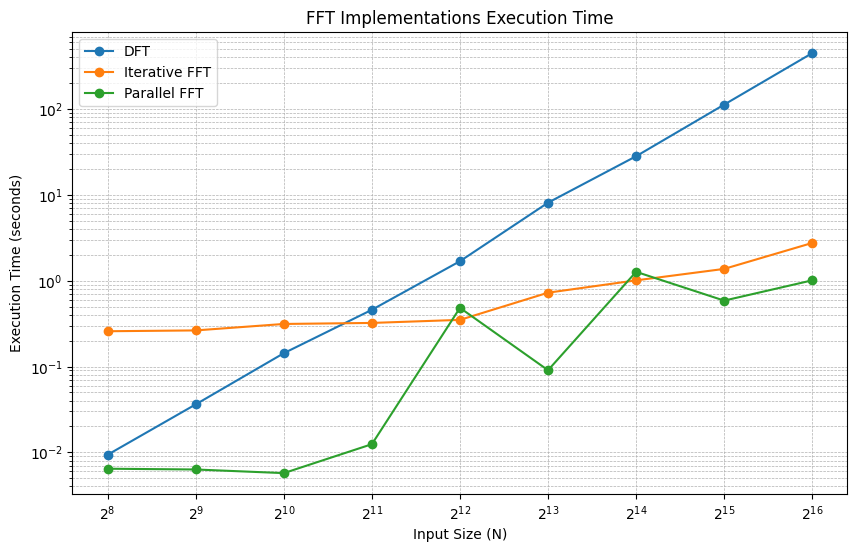

In [26]:
plt.figure(figsize=(10, 6))
for name, times in timings.items():
    plt.plot(input_sizes, times, label=name, marker='o')

plt.xlabel("Input Size (N)")
plt.ylabel("Execution Time (seconds)")
plt.title("FFT Implementations Execution Time")
plt.xscale("log", base=2)
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()